In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sympy import symbols, Eq

Dados do relatório

In [2]:
# pressao em cm hm
# erro a menor medição foi 1
dados = {
    'Pi': [8, 12, 9, 15, 14],
    'Pf': [44, 40, 30, 29, 22],
    'N': [10, 8, 6, 4, 2]
}

df = pd.DataFrame(dados)
df

,Pi,Pf,N
0,8,44,10
1,12,40,8
2,9,30,6
3,15,29,4
4,14,22,2


Pi = pressão inicial em mmhg


Pf = pressão final


N = qtd de faixas

# Primeiro gŕafico

Pi - Pf

scatter plot somente para visualização

Aqui é mais para mostrar os dados que coletamos no experimento, ainda não estamos resolvendo nem um dos items propostos no relatório

In [3]:
df['delta'] = (df['Pi'] - df['Pf']).abs()

Text(0, 0.5, 'Número de faixas')

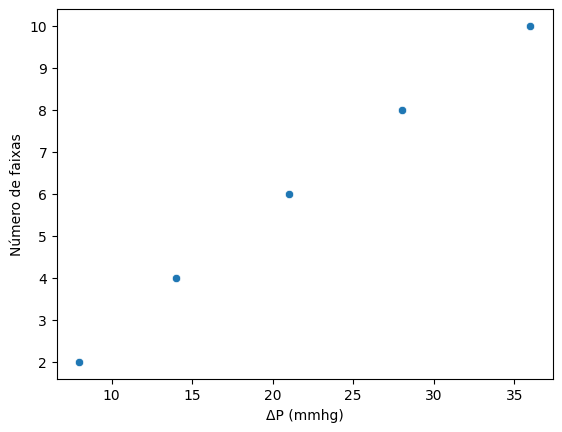

In [4]:
sns.scatterplot(data=df, x='delta', y='N')
plt.xlabel("ΔP (mmhg)")
plt.ylabel("Número de faixas")

# Item 1 e 2)

Primeira regressão linear do problema, vamos identificar a relação entre DeltaP (diferença de pressão) e N (número de faixas)

Equação 5 do relatório (Pin é pressão inicial, o software tratou Pi como o valor matemático 3.14...):

In [5]:
nf, ni, Pf, Pi, N, lambda_0, d = symbols('nf ni Pf Pin N lambda_0 d', real=True)

equation = Eq((nf - ni) / (Pf - Pi), (N * lambda_0) / (2 * d * (Pf - Pi)))
equation

Eq((nf - ni)/(Pf - Pin), N*lambda_0/(2*d*(Pf - Pin)))

simplificando:

In [6]:
equation = Eq((nf - ni), (N * lambda_0) / (2 * d))
equation

Eq(nf - ni, N*lambda_0/(2*d))

sabendo que o índice de refração tem a seguinte relação com a pressão:

In [7]:
n, k, p = symbols("n k p")
Eq(n, 1 + k * p)

Eq(n, k*p + 1)

pela equação acima podemos substituir ni e nf por pi e pf:

In [8]:
nf, ni, Pin, Pf = symbols("nf ni Pin Pf")
Eq(nf - ni, k*(Pf - Pin))

Eq(nf - ni, k*(Pf - Pin))

Então, temos:

In [9]:
k, Pf, Pin, N, lambda_0, d = symbols("k , Pf, Pin, N, lambda_0, d")
Eq(k*(Pf - Pin), N * lambda_0 / (2*d))

Eq(k*(Pf - Pin), N*lambda_0/(2*d))

aqui temos a resposta do item 1)

temos o DeltaP

N são as franjas dos dados que coletamos

d = 3cm (do roteiro)

λ_0 = 632.8 nm (do roteiro)

achando k, podemos substituir na fórmula que relaciona nf - ni = k (Pf - Pin)

assim teremos uma equação que relaciona o índice de refração do e a pressão absoluta do ar.

aqui vamos explorar os dados propostos para encontrar k e resolver o item 1, que é o item 2)

In [10]:
# todas as unidades abaixo estão em METROS
lambda_0 = 632.8e-9
d = 3e-2

df['y'] = df['N'] * lambda_0 / (2* d)

Observe a seguinte equação linear:

y = a * x + b

onde a é o "coef" e b é o "intercept"

as bibliotecas que fazem regressões lineares sempre dão a opção caso queremos ter o "b", no caso que estamos atuando, se olhar na fóruma anterior, vemos que não há
valor "livre", logo para o problema que estamos fazendo não podemos ter o b, assim iremos utilizar fit_intercept = false

In [11]:
ln = LinearRegression(fit_intercept=False)

In [12]:
ln.fit(df[['delta']], df[['y']])

LinearRegression(fit_intercept=False)

In [13]:
a = ln.coef_[0][0]

In [14]:
print(f"a equação linear é dada por y = {a:.7f} * x")

a equação linear é dada por y = 0.0000030 * x


então podemos construir a seguinte relação, (onde delta n é nf - ni (indice de refração final menos inicial)):

In [15]:
df['delta_n'] = a * df['delta']

# item 3)

Gráfico entre n e Par

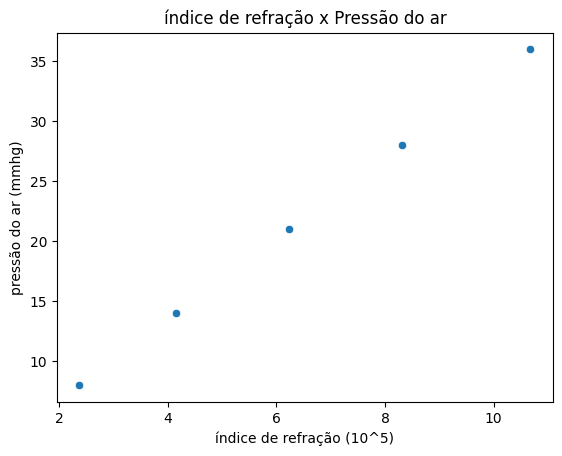

In [16]:
sns.scatterplot(x=df['delta_n']*1e5, y=df['delta'])
plt.xlabel("índice de refração (10^5)")
plt.ylabel("pressão do ar (mmhg)")
plt.title("índice de refração x Pressão do ar")
plt.show()

In [17]:
df

,Pi,Pf,N,delta,y,delta_n
0,8,44,10,36,0.000105,0.000107
1,12,40,8,28,0.000084,0.000083
2,9,30,6,21,0.000063,0.000062
3,15,29,4,14,0.000042,0.000042
4,14,22,2,8,0.000021,0.000024


# item 4)

Tínhamos encontrado a equação:

ni - nf = k(pi - pf)

então fazendo pi = 0 (vácuo) sabemos que ni é 1

então podemos:

nf = pf * k + 1 ( que é o que estamos calculando abaixo)

In [20]:
a * 760 + 1 # (o 1 é considerando que ni é o índice de refração no vácuo, e pi = 0 (vácuo))

np.float64(1.0022538996524033)